In [1]:
import numpy as np
import pandas as pd

from servo_positioning_system import simulate_servo_positioning_system
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [2]:
# random signal generation
def prbs(nstep):
    a_range = [0,2]
    a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
    
    b_range = [500, 2500]
    b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
    b = np.round(b)
    b = b.astype(int)

    b[0] = 0
    
    for i in range(1,np.size(b)):
        b[i] = b[i-1]+b[i]
        
    # PRBS
    a = np.zeros(nstep)
    j = 0
    while j < nstep:
        a[j] = 20
        a[j+1] = -20
        j = j+2
    
    i=0
    prbs = np.zeros(nstep)
    while b[i]<np.size(prbs):
        k = b[i]
        prbs[k:] = a[i]
        i=i+1
        
    return prbs

In [3]:
# nstep = 300
# 
# # random signal generation
# 
# a_range = [0,2]
# a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
# 
# b_range = [2, 10]
# b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
# b = np.round(b)
# b = b.astype(int)
# 
# b[0] = 0
# 
# for i in range(1,np.size(b)):
#     b[i] = b[i-1]+b[i]
# 
# # Random Signal
# i=0
# random_signal = np.zeros(nstep)
# while b[i]<np.size(random_signal):
#     k = b[i]
#     random_signal[k:] = a[i]
#     i=i+1
# 
# # PRBS
# a = np.zeros(nstep)
# j = 0
# while j < nstep:
#     a[j] = 5
#     a[j+1] = -5
#     j = j+2
# 
# i=0
# prbs = np.zeros(nstep)
# while b[i]<np.size(prbs):
#     k = b[i]
#     prbs[k:] = a[i]
#     i=i+1
# 
# plt.figure(0) 
# plt.subplot(2,1,1)
# plt.plot(random_signal, drawstyle='steps',label='Random Signal')
# plt.legend()
# plt.subplot(2,1,2)
# plt.plot(prbs, drawstyle='steps', label='PRBS')
# plt.legend()
# plt.show()

In [4]:
n_u = 1
n_x = 3
n_y = 3

u_std = 5
perturbation = 0.3 # each param can vary of perturbation %

T = 10
Ts = 0.0001
t = np.arange(0,T,Ts)
# input signal
u_s = np.array([1e-3])



#u = u_std * np.random.randn(*t.shape,n_u) + u_s
u = np.zeros((*t.shape,n_u))
u[:,0] = prbs(t.shape[0])
# output signal
x, u, y = simulate_servo_positioning_system(Ts, u, perturbation)

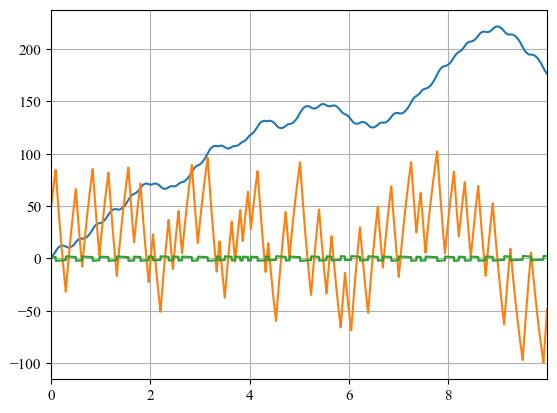

In [5]:
plt.plot(t, x)

In [6]:
N = 50 # n. of test experiments

u_test = np.zeros((N, *u.shape))
x_test = np.zeros((N, *y.shape))   # state with process noise
y_test = np.zeros((N, *y.shape))   # output with measurement noise (we assume n_y=2)

data_test = [None] * N

for i in range(N): # generate N I/O sets of data 
    u = np.zeros((*t.shape,n_u))
    u[:,0] = prbs(t.shape[0]) + u_s[0]
    u_test[i,:,:] = u
    # u_test[i,:,:] = u_std * np.random.randn(*t.shape,n_u) + u_s
    # u_test[i,:,:] = u
    # output signal
    x_test[i,:,:], _, y_test[i,:,:], data_test[i] = simulate_servo_positioning_system(Ts, u_test[i,:,:], perturbation, save_params=True, process_noise=True)

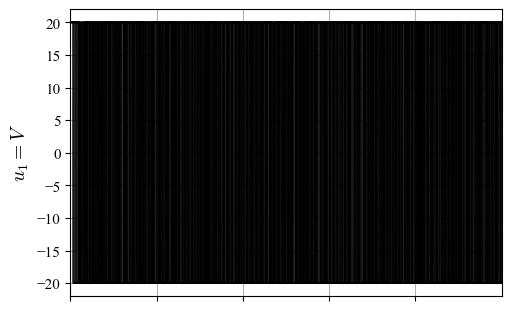

In [7]:
plt.figure(figsize=(5,3), constrained_layout=True)

ax1 = plt.subplot(111)
plt.plot(t, u_test[:,:,0].T, c='k', alpha=0.3, linewidth=1)
plt.tick_params('x', labelbottom=False)
plt.ylabel(r'$u_1 = V$')

plt.show()

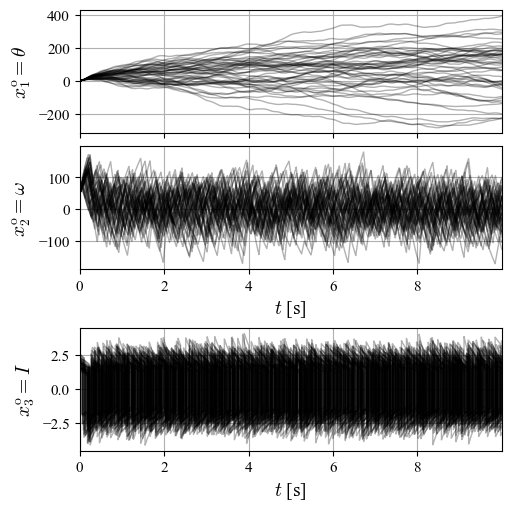

In [8]:
plt.figure(figsize=(5,5), constrained_layout=True)

ax1 = plt.subplot(311)
plt.plot(t, x_test[:,:,0].T, c='k', alpha=0.3, linewidth=1)
plt.tick_params('x', labelbottom=False)
plt.ylabel(r'$x^{\mathrm{o}}_1 = \theta$')

ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t, x_test[:,:,1].T, c='k', alpha=0.3, linewidth=1)
plt.ylabel('$x^{\mathrm{o}}_2 = \omega$')
plt.xlabel('$t$ [s]')

ax2 = plt.subplot(313, sharex=ax1)
plt.plot(t, x_test[:,:,2].T, c='k', alpha=0.3, linewidth=1)
plt.ylabel('$x^{\mathrm{o}}_3 = I$')
plt.xlabel('$t$ [s]')

# plt.tight_layout()

# plt.savefig('meta_set.pdf')

plt.show()

In [11]:
import pickle as pkl
test_set = {'t':t, 'u_test':u_test, 'x_test':x_test, 'y_test':y_test, 'data_test':data_test}
with open('../data/control/test_set_prbs.pkl', 'wb') as f:
    pkl.dump(test_set, f)